[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Using deep learning to caption images


This notebook develops a deep learning model to generate captions for images.

Note: results are shown in section 4.5. at the end of the notebook.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/gdrive
Note: using Google CoLab


In [2]:
if COLAB:
    # get gpu info
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Currently not using gpu')
    else:
        print(gpu_info)

    # get RAM info
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    if ram_gb > 20:
        print('You are using a high-RAM runtime!')        

Tue Apr  6 23:00:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
if COLAB:
    basedir = "/content/gdrive/MyDrive/Machine_Learning_Projects/image-captioning-1.1"
else:
    basedir = "./"

# Download dataset

In [ ]:
#import os
#os.getcwd()

In [ ]:
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
#os.listdir()

In [ ]:
#!unzip Flickr8k_Dataset.zip

In [ ]:
#os.listdir()

In [ ]:
#len(os.listdir("/content/Flicker8k_Dataset/"))

# Import needed modules

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pickle import dump
from pickle import load
import string

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

# 1. Extract features from each image in the directory and save as pickle file
Note: This should be done once and takes about 40 minutes

In [5]:
def extract_features(directory):
    model = InceptionV3(weights='imagenet')
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    #print(model.summary())
    
    features = dict()
    for name in tqdm(os.listdir(directory)):
        filename = f"{directory}/{name}"
        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split(".")[0]
        features[image_id] = feature
        #print(name, "feature extracted")
    return features

In [6]:
# extract features from all images in directory using VGG16
#directory = "/content/Flicker8k_Dataset"
#features = extract_features(directory)
#print(f"Extracted a total of {len(features)} features")

# save features as pkl file for future use
#filename = os.path.join(basedir, "features.pkl")
#dump(features, open(filename, "wb"))

# 2. Get descriptions of each image and save it to file

In [7]:
def load_doc(filename):
    ''' load document into memory '''
    file = open(filename, "r")
    text = file.read()
    file.close()
    return text

def load_descriptions(doc):
    ''' extract descriptions for images '''
    mapping = dict()
    for line in doc.split("\n"):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split(".")[0]
        image_desc = " ". join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    '''
    clean descriptions:
    1. convert to lowercase
    2. removing punctuation
    3. remove one character words (e.g. "a")
    4. remove words with numbers in them 
    '''
    
    table = str.maketrans("","", string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            # clean descriptions
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            # store desc as one string
            desc_list[i] = " ".join(desc)

def to_vocabulary(descriptions):
    ''' extract all unique words form all image descriptions '''
    unique_words = set()
    for key in descriptions.keys():
        [unique_words.update(desc.split()) for desc in descriptions[key]]
    return unique_words

def save_descriptions(descriptions, filename):
    ''' save descriptions to file '''
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + " " + desc)
    data = "\n".join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()

In [8]:
# load descriptions from file
filename = os.path.join(basedir, "Flickr8k_text/Flickr8k.token.txt")
doc = load_doc(filename)

# parse descriptions into dictionary{image_id:[descriptions]}
descriptions = load_descriptions(doc)
print(f"Descriptions obtained for {len(descriptions)} images")

# clean descriptions
clean_descriptions(descriptions)

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print("Vocabulary size:", len(vocabulary))

# save descriptions for each image to file
save_descriptions(descriptions, os.path.join(basedir,"descriptions.txt"))

Descriptions obtained for 8092 images
Vocabulary size: 8763


# 3. Define utility functions and deep learning model

## 3.1. Funcitons for loading dataset, descriptions, and features for either train, validation, or test

In [9]:
def load_set(filename):
    ''' load a pre-define list of image identifiers form file '''
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split("\n"):
        if len(line) < 1:
            continue
        image_id = line.split(".")[0]
        dataset.append(image_id)
    return set(dataset)

def load_clean_descriptions(filename, dataset):
    ''' load cleaned descriptions from file '''
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split("\n"):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = "startseq " + " ".join(image_desc) + " endseq"
            descriptions[image_id].append(desc)
    return descriptions

def load_image_features(filename, dataset):
    all_features = load(open(filename, "rb"))
    features = {k: all_features[k] for k in dataset}
    return features

## 3.2. Functions for tokenizing descriptions

In [10]:
def to_lines(descriptions):
    ''' turn dict of descriptions to a list for tokenizer '''
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    ''' tokenize all descriptions '''
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_length(descriptions):
    ''' calculate the length of description with the maximum length '''
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

## 3.3. Function for creating input sequences used by model

To understand the input format to the model for training, take for example if image_1 has the description of "*little girl running in field*", it would be split as follows:

```
X1,        X2 (text sequence),                           y (word)
image_1    startseq,                                     little
image_1    startseq, little,                             girl
image_1    startseq, little, girl,                       running
image_1    startseq, little, girl, running,              in
image_1    startseq, little, girl, running, in,          field
image_1    startseq, little, girl, running, in, field,   endseq
```

In [11]:
def data_generator(tokenizer, max_seqlength, descriptions, images, vocab_size, numImagesPerBatch):
    ''' create sequences of images, input sequences and output words for an image '''
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_seqlength)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(images[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == numImagesPerBatch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

## 3.4. Define deep learning model to caption the images

In [12]:
def define_model(vocab_size, max_seqlength, embedding_dim, basedir):
    ''' create deep learning model for image captioning'''
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation="relu")(fe1)
    
    # sequence model
    inputs2 = Input(shape=(max_seqlength,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation="relu")(decoder1)
    outputs = Dense(vocab_size, activation="softmax")(decoder2)
    
    # putting the model together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    # model summary
    print(model.summary())
    filename = os.path.join(basedir, "Figures", "model.png")
    plot_model(model, to_file=filename, show_shapes=True)
    
    return model

## 3.5. Load training dataset and tokenize training descriptions

In [13]:
# load train dataset (6K)
filename = os.path.join(basedir, "Flickr8k_text/Flickr_8k.trainImages.txt")
train_dataset = load_set(filename)
print("Train dataset:", len(train_dataset))

# load train dataset descriptions
filename = os.path.join(basedir, "descriptions.txt")
train_descriptions = load_clean_descriptions(filename, train_dataset)
print("Descriptions: train=", len(train_descriptions))

# load train image features
filename = os.path.join(basedir, "features.pkl")
train_features = load_image_features(filename, train_dataset)
print("Images: train=", len(train_features))

# tokenize train_descriptions
tokenizer = create_tokenizer(train_descriptions)
word2index = dict()
index2words = dict()
for word, index in tokenizer.word_index.items():
    word2index[word] = index
    index2words[index] = word
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

# determine the maximum sequence length
max_seqlength = max_length(train_descriptions)
print("Maximum description length:", max_seqlength)

Train dataset: 6000
Descriptions: train= 6000
Images: train= 6000
Vocabulary size: 7579
Maximum description length: 34


## 3.6. Load validation dataset

In [14]:
# load val dataset
filename = os.path.join(basedir, "Flickr8k_text/Flickr_8k.devImages.txt")
val_dataset = load_set(filename)
print("Validation dataset:", len(val_dataset))

# load validation dataset descriptions
filename = os.path.join(basedir, "descriptions.txt")
val_descriptions = load_clean_descriptions(filename, val_dataset)
print("Descriptions: validataion=", len(val_descriptions))

# load validation image features
filename = os.path.join(basedir, "features.pkl") 
val_features = load_image_features(filename, val_dataset)
print("Images: validation=", len(val_features))

Validation dataset: 1000
Descriptions: validataion= 1000
Images: validation= 1000


# 3.7. Load GloVe embeddings

In [15]:
f = open(os.path.join(basedir, "glove.6B.200d.txt"))
embeddings_index = dict()
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

400000it [00:20, 19546.41it/s]


In [16]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():  
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 3.7. Fit model
Note: reduce ```train_numImagesPerBatch``` if you run out of RAM.

In [17]:
fit_model = True
if fit_model:
    # prepare training dataset
    train_numImagesPerBatch = 100
    train_generator = data_generator(tokenizer, max_seqlength, train_descriptions, train_features, vocab_size, train_numImagesPerBatch)

    # prepare validation dataset
    val_numImagesPerBatch = len(val_features)
    val_generator = data_generator(tokenizer, max_seqlength, val_descriptions, val_features, vocab_size, val_numImagesPerBatch)
    Xval, yval = next(val_generator)

    # define the model
    model = define_model(vocab_size, max_seqlength, embedding_dim, basedir)
    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False
    model.compile(loss="categorical_crossentropy", optimizer="adam")

    # define checkpoint callback
    filepath = os.path.join(basedir, "Models", "model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5")
    checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min")

    # fit model
    steps = len(train_descriptions) // train_numImagesPerBatch
    history = model.fit(train_generator, epochs=20, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint], validation_data=(Xval, yval))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      1515800     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

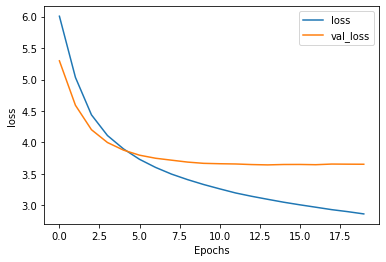

In [18]:
def plot_graphs(history, info2plot):
  plt.plot(history.history[info2plot])
  plt.plot(history.history['val_'+info2plot])
  plt.xlabel("Epochs")
  plt.ylabel(info2plot)
  plt.legend([info2plot, 'val_'+info2plot])
  plt.savefig(os.path.join(basedir, "Figures", f"{info2plot}.png"))
  plt.show()

if fit_model:  
    plot_graphs(history, "loss")


# 4. Evaluate model

## 4.1. Functions for generating image description from model predictions

In [19]:
def token2word(integer, tokenizer):
    ''' map token (integer) to word '''
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def greedy_search(model, tokenizer, image, max_seqlength):
    ''' generate description for a given image '''
    seed_text = "startseq"
    for i in range(max_seqlength):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([seed_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_seqlength)
        # make prediction
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        # map predicted integer to word
        word = token2word(yhat, tokenizer)
        #word = tokenizer.sequences_to_texts([[yhat]])[0]
        if word is None:
            break
        seed_text += " " + word
        if word == "endseq":
            break
    return seed_text


def beam_search(model, tokenizer, image, max_seqlength, beam_size):
    ''' generate description for a given image '''
    start_index = tokenizer.texts_to_sequences(["startseq"])[0]
    sequences = [[start_index, 0.0]]
    while len(sequences[0][0]) < max_seqlength:
        temp_candidates = list()
        for seq in sequences:
            paded_seq = pad_sequences([seq[0]], maxlen=max_seqlength)
            # make prediction
            yhat = model.predict([image, paded_seq], verbose=0)
            top_yhat_indices = np.argsort(yhat[0])[-beam_size:]
            for index in top_yhat_indices:
                next_index, score = seq[0][:], seq[1]
                next_index.append(index)
                #score += np.log(yhat[0][index])
                score += yhat[0][index]
                temp_candidates.append([next_index, score])

        sequences = temp_candidates
        # Sort according to score
        sequences = sorted(sequences, reverse=False, key=lambda x: x[1])
        # Get the top scoring sequence
        sequences = sequences[-beam_size:]

    # Get best sequence
    sequences = sequences[-1][0]
    intermediate_desc = tokenizer.sequences_to_texts([sequences])[0]
    final_desc = list()
    for word in intermediate_desc.split():
        final_desc.append(word)
        if word == "endseq":
            break    
    final_desc = " ".join(final_desc)
    return final_desc



def predict_descriptions(model, descriptions, images, tokenizer, max_seqlength, beam_size):
    actual, predicted = dict(), dict()
    # step over the whole test dataset
    for key, desc_list in tqdm(descriptions.items()):
        if beam_size < 1:
            raise ValueError("beam_size must be > 1")
        elif beam_size == 1:
            yhat = greedy_search(model, tokenizer, images[key], max_seqlength)
        else:
            yhat = beam_search(model, tokenizer, images[key], max_seqlength, beam_size)
        reference = [d.split() for d in desc_list]
        actual[key] = reference
        predicted[key] = yhat.split()
    return actual, predicted

## 4.3. Load test dataset

In [20]:
filename = os.path.join(basedir, "Flickr8k_text/Flickr_8k.testImages.txt")
test_dataset = load_set(filename)
print("Test dataset:", len(test_dataset))

# load test dataset descriptions
filename = os.path.join(basedir, "descriptions.txt")
test_descriptions = load_clean_descriptions(filename, test_dataset)
print("Descriptions: test=", len(test_descriptions))

# load test image features
filename = os.path.join(basedir, "features.pkl")
test_features = load_image_features(filename, test_dataset)
print("Images: test=", len(test_features))

Test dataset: 1000
Descriptions: test= 1000
Images: test= 1000


## 4.3. Load the model and get prediction on test dataset

In [21]:
# Selected images for testing
selected_images = ["1119015538_e8e796281e", "300314926_0b2e4b64f5", "3432550415_e7b77232de", "1084040636_97d9633581"]

In [23]:
filename = os.path.join(basedir, "Models", "model-ep014-loss3.097-val_loss3.644.h5")
model = load_model(filename)

beam_size = 1
sub_test_features = {k: test_features[k] for k in selected_images}
sub_test_descriptions = {k: test_descriptions[k] for k in selected_images}
#actual, predicted = predict_descriptions(model, sub_test_descriptions, sub_test_features, tokenizer, max_seqlength, beam_size)
actual, predicted = predict_descriptions(model, test_descriptions, test_features, tokenizer, max_seqlength, beam_size)

100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


## 4.4. Calculate the overall BLEU score

In [24]:
actual_list = list(actual.values())
predicted_list = list(predicted.values())
print('BLEU-1: %f' % corpus_bleu(actual_list, predicted_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_list, predicted_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_list, predicted_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_list, predicted_list, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.585052
BLEU-2: 0.350607
BLEU-3: 0.250693
BLEU-4: 0.126548


## 4.5. Lets caption some images!


 Prediction Caption: two dogs play in the grass


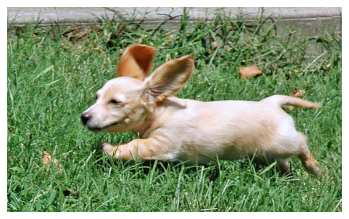


 Prediction Caption: man in blue wetsuit is riding his surfboard on the beach


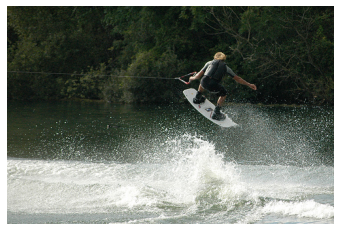


 Prediction Caption: man in blue shirt is doing tricks on skateboard


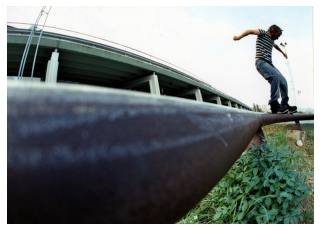


 Prediction Caption: dog is running through the snow


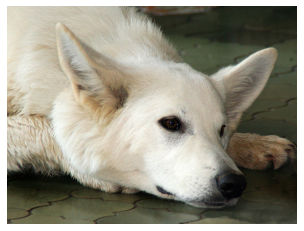

In [25]:
for image in selected_images:
    image_path = os.path.join(basedir, "Flicker8k_Dataset", f"{image}.jpg")
    print("\n Prediction Caption:", " ".join(predicted[image][1:-1]))
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.show()

It's quite astounding how some of the predictions are so accurate. However, the model was wrong on the last prediction.

Give it a try with your own images. Don't be too harsh on the model, it is still learning.

# Dataset source
*   [Flickr8k_Dataset](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip)
*   [Flickr8k_text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)



# Acknowledgement
Credit to [Jason Brownlee](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/) for the awesome tutorial which made creating this notebook possible.